# Database performance tests

In [1]:
import subprocess
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm, trange

from dunderlab.api import aioAPI as API
from dunderlab.api.utils import JSON, profile, get_data

In [2]:
api = API('http://localhost:9000/timescaledbapp/')
await api.endpoints()

{'source': 'http://localhost:9000/timescaledbapp/source/',
 'measure': 'http://localhost:9000/timescaledbapp/measure/',
 'channel': 'http://localhost:9000/timescaledbapp/channel/',
 'chunk': 'http://localhost:9000/timescaledbapp/chunk/',
 'timeserie': 'http://localhost:9000/timescaledbapp/timeserie/'}

In [3]:
async def configure_database(channels, chunks):
    source_response = await api.source.post({
        'label': 'Test.v1',
        'name': 'Test Database',
        'location': 'Eje Cafetero',
        'device': 'None',
        'protocol': 'None',
        'version': '0.1',
        'description': 'Sample database for TimeScaleDBApp',
    })

    measure_response = await api.measure.post({
        'source': 'Test.v1',
        'label': 'measure_01',
        'name': 'Measure 01',
        'description': 'Simple sinusoidals for 64 channels at different frequencies',
    })

    channel_response = await api.channel.post([{
        'source': 'Test.v1',
        'measure': 'measure_01',
        'name': f'Channel {channel}',
        'label': f'ch-{str(channel).rjust(2, "0")}',
        'unit': 'u',
        'sampling_rate': '1000',
        } for channel in range(1, channels+1)])
    
    chunk_response = await api.chunk.post([{
        'measure': 'measure_01',
        'label': chunk,
    } for chunk in chunks])
    

## Single submitting

Write `1M` of data for each channel in blocks of `1k`.

In [4]:
async def single_submitting(channels, chunks):
    write = []
    # Iterate by 1000 packages
    for t in (pbar := trange(1000)):
        pbar.set_description(f"Submitting")
        timestamp = np.linspace(t*1000, (t+1)*1000, 1000, endpoint=False)
        # add 1000 points
        data = {
            'source': 'Test.v1',
            'measure': 'measure_01',
            'timestamps': list(timestamp),
            'values': {f'ch-{str(ch+1).rjust(2, "0")}':list(np.sin(2*np.pi*(ch+1)*timestamp)) for ch in range(channels)},
        }
        data_size = len(timestamp)*channels
        with profile:
            # write 1000 points
            await api.timeserie.post({**data, 'chunk': np.random.choice(chunks)})
        write.append(data_size/profile.execution_time)
    return write

## Batched submitting

Write `1M` of data for each channel in blocks of `1k` x `100` using batch sizes of `1` and repeating `10` times.

In [5]:
async def multiple_submitting(channels, chunks, batch_size=1):
    write = []
    # Iterate by 100 of something
    for i in (pbar := trange(100)):
        pbar.set_description(f"Submitting")
        data = []
        # Iterate by 10 packages 
        for t in range(i*10, (i+1)*10):
            timestamp = np.linspace(t*1000, (t+1)*1000, 1000, endpoint=False)
            # add 1000 points
            data.append({
                'source': 'Test.v1',
                'measure': 'measure_01',
                'timestamps': list(timestamp),
                'values': {f'ch-{str(ch+1).rjust(2, "0")}':list(np.sin(2*np.pi*(ch+1)*timestamp)) for ch in range(channels)},
                'chunk': np.random.choice(chunks),
            })
        data_size = len(timestamp)*channels*10
        with profile:
            # write 100x1000 points
            await api.timeserie.post(data, batch_size=batch_size)
        write.append(data_size/profile.execution_time)
    return write

## Single retrieve

In [6]:
async def single_retrieve(api, page_size=100, chunks=[], batch_size=None):
    with profile:
        timeseries_response = await api.timeserie.get({
            'source': 'Test.v1',
            'measure': 'measure_01',
            'page_size': int(page_size),
            'timestamps': 'false',
            'chunks': chunks,
        },
        batch_size=batch_size
        )
    
    try:
        data_timeseries_response = await anext(timeseries_response)
    except:
        data_timeseries_response = timeseries_response
    data = get_data(data_timeseries_response)
    if isinstance(data, tuple):
        data, _ = data
    if batch_size:
        s = data.size #* len(timeseries_response)
    else:
        s = data.size
    return s, s/profile.execution_time

## Performance

In [7]:
async def submit(channels, chunks, submit_batches=False):
    chunks = [f'chunk-{chunk}' for chunk in range(chunks)]
    await configure_database(channels, chunks)

    if submit_batches:
        data = await multiple_submitting(channels, chunks, submit_batches)
        filename = os.path.join('results', f'submitting.{channels}ch.{len(chunks)}chunks.{submit_batches}batchsize')
    else:
        data = await single_submitting(channels, chunks)
        filename = os.path.join('results', f'submitting.{channels}ch.{len(chunks)}chunks')
    
    np.savez(filename, submitting=data)
    return filename
    
async def retrieve(channels, chunks, retrieve_batches=0):
    max_retrieve = int(100000/channels)
    data = []
    if retrieve_batches:
        filename = os.path.join('results', f'retrieving.{channels}ch.{chunks}chunks.{retrieve_batches}batchsize')
        for s in (pbar := tqdm(np.linspace(0, max_retrieve, 101, endpoint=True)[1:])):
            pbar.set_description(f"Retrieving {int(s)} samples using bach_size={int(s/retrieve_batches)}")
            data.append(await single_retrieve(api, page_size=s, batch_size=int(s/retrieve_batches)))
    else:
        filename = os.path.join('results', f'retrieving.{channels}ch.{chunks}chunks')
        for s in (pbar := tqdm(np.linspace(0, max_retrieve, 101, endpoint=True)[1:])):
            pbar.set_description(f"Retrieving {int(s)} samples")
            data.append(await single_retrieve(api, page_size=s))

    np.savez(filename, retrieving=data)
    return filename
    

def viz(submitting_filename, retrieving_filename, window_size=31):
    performace = np.load(f'{submitting_filename}.npz')['submitting']

    plt.figure(figsize=(20, 5), dpi=90)
    plt.suptitle(f"Performace")

    plt.subplot(121)
    plt.hist(performace, color='C0', alpha=0.5, zorder=10)
    plt.title(submitting_filename.replace('.', ' ').capitalize())
    plt.xlabel('Insertion (samples per second)')
    plt.ylabel('Count')
    plt.grid(True, zorder=0)

    plt.subplot(122)
    performace = np.load(f'{retrieving_filename}.npz')['retrieving']
    plt.plot(*zip(*performace), 'o', markersize=5, alpha=0.5, zorder=10)
    plt.title(retrieving_filename.replace('.', ' ').capitalize())
    plt.xlabel('Data querying')
    plt.ylabel('Data per second')
    plt.grid(True, zorder=0)

## Experiment

In [7]:
experiments = (
    # {'channels': 1,  'chunks': 1,   'submit_batches': False, 'retrieve_batches': False},
    {'channels': 1,  'chunks': 100, 'submit_batches': False, 'retrieve_batches': False},
    # {'channels': 1,  'chunks': 1,   'submit_batches': 1, 'retrieve_batches': 10},
    {'channels': 1,  'chunks': 100, 'submit_batches': 1, 'retrieve_batches': 10},
    
    # {'channels': 32, 'chunks': 1,   'submit_batches': False, 'retrieve_batches': False},
    {'channels': 32, 'chunks': 100, 'submit_batches': False, 'retrieve_batches': False},
    # {'channels': 32, 'chunks': 1,   'submit_batches': 1, 'retrieve_batches': 10},
    {'channels': 32, 'chunks': 100, 'submit_batches': 1, 'retrieve_batches': 10},
)

## Reset database

In [9]:
working_directory = '/home/yeison/Development/PythonDev/DunderLab/django-apps/python-django-timescaledbapp/example'
command = "source /home/yeison/Development/PythonDev/DunderLab/venv311/bin/activate; docker rm timescaledbapp_v1; docker stop timescaledbapp_v1; timescaledbapp_create --name timescaledbapp_v1; djangoship restart; python manage.py migrate timescaledbapp --database='timescaledb'; docker inspect -f '{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}' timescaledbapp_v1"
reset_database = lambda :subprocess.run(command, shell=True, cwd=working_directory, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

## Run

In [ ]:
for experiment in (pbar := tqdm(experiments)):
    pbar.set_description(f"Resetting database")
    reset_database()
    time.sleep(2)  # wait for changes propagation.
    pbar.set_description(f"Experiment {experiment}")
    submit_filename = await submit(channels=experiment['channels'], chunks=experiment['chunks'], submit_batches=experiment['submit_batches'])
    retrieve_filename = await retrieve(channels=experiment['channels'], chunks=experiment['chunks'], retrieve_batches=experiment['retrieve_batches'])
    viz(submit_filename, retrieve_filename)

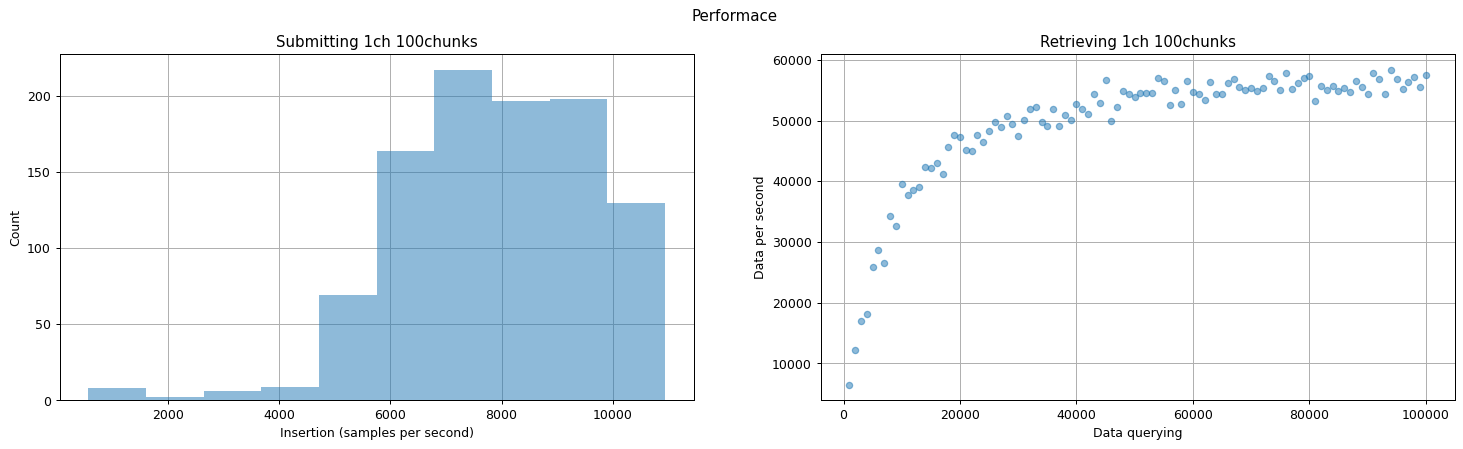

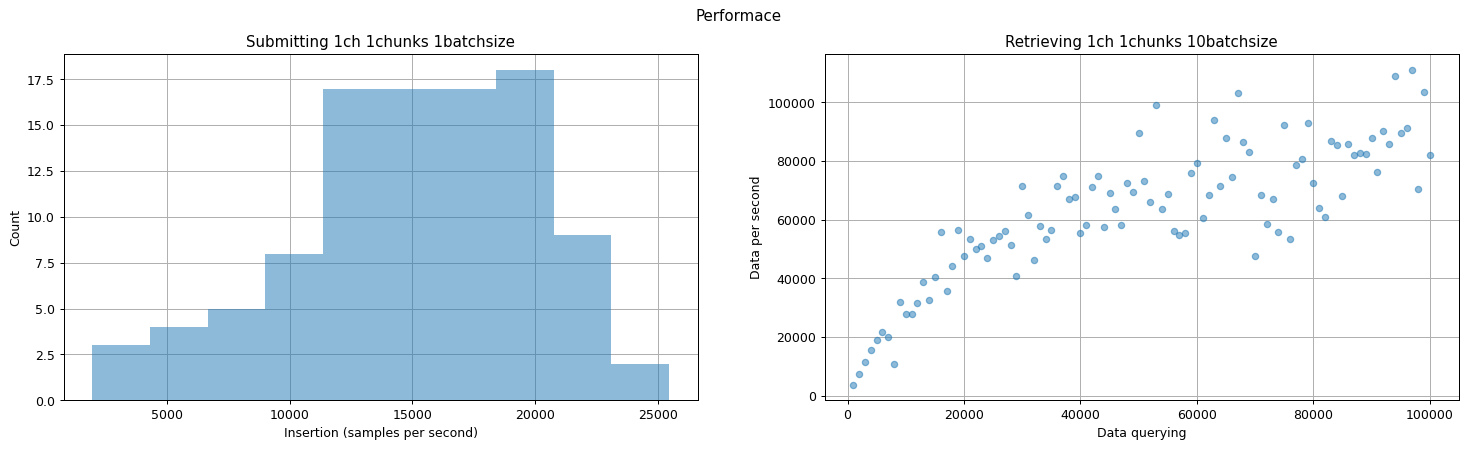

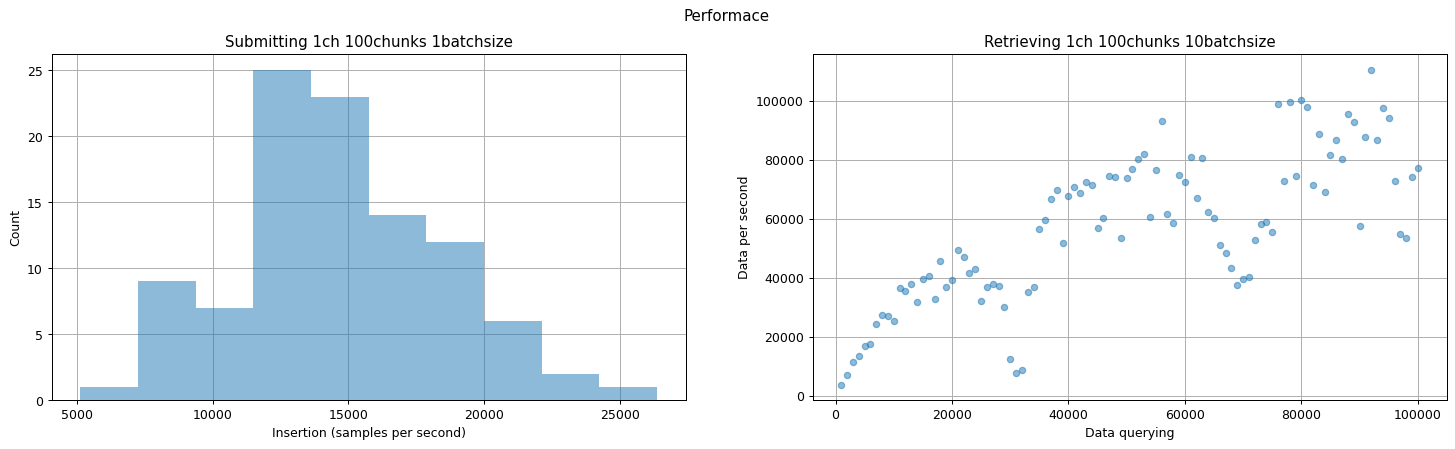

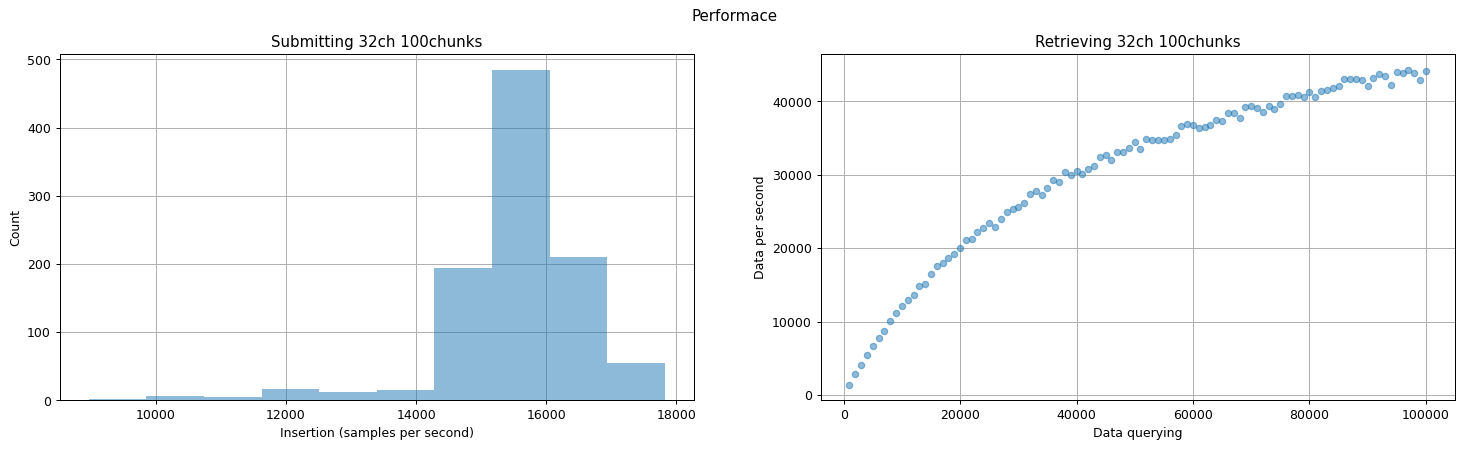

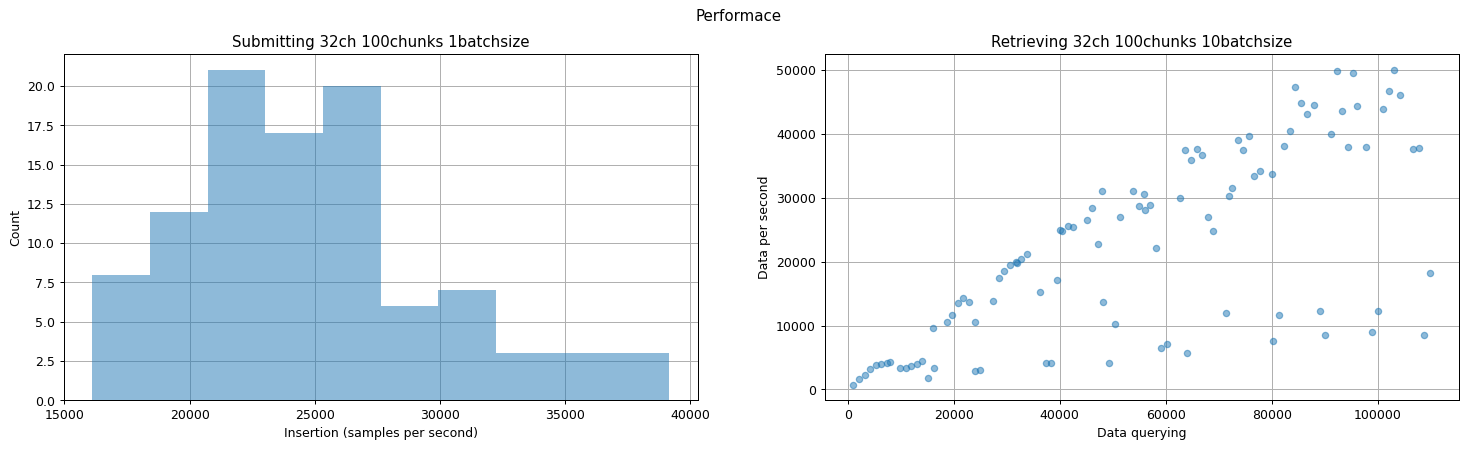

In [12]:
# viz('submitting.1ch.1chunks',               'retrieving.1ch.1chunks')
viz('submitting.1ch.100chunks',             'retrieving.1ch.100chunks')
# viz('submitting.1ch.1chunks.1batchsize',    'retrieving.1ch.1chunks.10batchsize')
: 'EEG',
    'name': 'Electroencephalography'
})viz('submitting.1ch.100chunks.1batchsize',  'retrieving.1ch.100chunks.10batchsize')
# viz('submitting.32ch.1chunks',              'retrieving.32ch.1chunks')
viz('submitting.32ch.100chunks',            'retrieving.32ch.100chunks')
# viz('submitting.32ch.1chunks.1batchsize',   'retrieving.32ch.1chunks.10batchsize')
viz('submitting.32ch.100chunks.1batchsize', 'retrieving.32ch.100chunks.10batchsize')

In [9]:
#await submit(channels=32, chunks=10, submit_batches=1)

  0%|          | 0/100 [00:00<?, ?it/s]

'submitting.32ch.10chunks.1batchsize'